# Assignment 9: GBDT

In [1]:
# importing the necessary libraries 

%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import math as m
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
import re
from scipy import sparse
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import Normalizer
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from tqdm import tqdm

import nltk
nltk.download('vader_lexicon')
from nltk.sentiment.vader import SentimentIntensityAnalyzer
sid = SentimentIntensityAnalyzer()
import pickle
from prettytable import PrettyTable
from prettytable import ALL as ALL

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


#### Response Coding: Example

<img src='http://i.imgur.com/TufZptV.jpg' width=700px>

> The response tabel is built only on train dataset.
> For a category which is not there in train data and present in test data, we will encode them with default values
Ex: in our test data if have State: D then we encode it as [0.5, 0.05]

<ol>
    <li><strong>Apply GBDT on these feature sets</strong>
        <ul>
            <li><font color='red'>Set 1</font>: categorical(instead of one hot encoding, try <a href='https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/handling-categorical-and-numerical-features/'>response coding</a>: use probability values), numerical features + project_title(TFIDF)+  preprocessed_eassay (TFIDF)+sentiment Score of eassay(check the bellow example, include all 4 values as 4 features)</li>
            <li><font color='red'>Set 2</font>: categorical(instead of one hot encoding, try <a href='https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/handling-categorical-and-numerical-features/'>response coding</a>: use probability values), numerical features + project_title(TFIDF W2V)+  preprocessed_eassay (TFIDF W2V)</li>        
    </li>
    <li> Here in response encoding you need to apply the <strong>laplase smoothing</strong> value for test set. Laplase smoothing means, If test point is present in test but not in train then you need to apply default 0.5 as probability value for that data point (Refer the Response Encoding Image from above cell) </li>
    <li>Please use atleast <strong> 35k </strong> data points </li></ul>
    <li><strong>The hyper paramter tuning (Consider any two hyper parameters)</strong>
        <ul>
    <li>Find the best hyper parameter which will give the maximum <a href='https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/receiver-operating-characteristic-curve-roc-curve-and-auc-1/'>AUC</a> value</li>
    <li>find the best hyper paramter using k-fold cross validation/simple cross validation data</li>
    <li>use gridsearch cv or randomsearch cv or you can write your own for loops to do this task</li>
        </ul>
    </li>
    <li>
    <strong>Representation of results</strong>
        <ul>
    <li>You need to plot the performance of model both on train data and cross validation data for each hyper parameter, like shown in the figure
    <img src='https://i.imgur.com/Gp2DQmh.jpg' width=500px> with X-axis as <strong>n_estimators</strong>, Y-axis as <strong>max_depth</strong>, and Z-axis as <strong>AUC Score</strong> , we have given the notebook which explains how to plot this 3d plot, you can find it in the same drive <i>3d_scatter_plot.ipynb</i></li>
            <p style="text-align:center;font-size:30px;color:red;"><strong>or</strong></p> <br>
    <li>You need to plot the performance of model both on train data and cross validation data for each hyper parameter, like shown in the figure
    <img src='https://i.imgur.com/fgN9aUP.jpg' width=300px> <a href='https://seaborn.pydata.org/generated/seaborn.heatmap.html'>seaborn heat maps</a> with rows as <strong>n_estimators</strong>, columns as <strong>max_depth</strong>, and values inside the cell representing <strong>AUC Score</strong> </li>
    <li>You choose either of the plotting techniques out of 3d plot or heat map</li>
    <li>Once after you found the best hyper parameter, you need to train your model with it, and find the AUC on test data and plot the ROC curve on both train and test.
        Make sure that you are using predict_proba method to calculate AUC curves, because AUC is calcualted on class probabilities and not on class labels.
    <img src='https://i.imgur.com/wMQDTFe.jpg' width=300px></li>
    <li>Along with plotting ROC curve, you need to print the <a href='https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/confusion-matrix-tpr-fpr-fnr-tnr-1/'>confusion matrix</a> with predicted and original labels of test data points
    <img src='https://i.imgur.com/IdN5Ctv.png' width=300px></li>
            </ul>
    <br>
    <li>You need to summarize the results at the end of the notebook, summarize it in the table format
        <img src='http://i.imgur.com/YVpIGGE.jpg' width=400px>
    </li>
</ol>

# Few Notes

1. Use atleast 35k data points
2. Use classifier.Predict_proba() method instead of predict() method while calculating roc_auc scores
3. Be sure that you are using laplase smoothing in response encoding function. Laplase smoothing means applying the default (0.5) value to test data if the test data is not present in the train set


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


<h1>1. GBDT (xgboost/lightgbm) </h1>

## 1.1 Loading Data

In [3]:
import pandas
data = pandas.read_csv('/content/drive/MyDrive/preprocessed_data (1).csv')

In [4]:
negative = []  # created a variable name 
positive = []
neutral = []
compound = []

# now here will add value to variables 
def update_sentiments(values):
    negative.append(values["neg"])    
    positive.append(values["pos"])
    neutral.append(values["neu"])
    compound.append(values["compound"])

In [5]:
from tqdm import tqdm
for essay in tqdm(data["essay"]):
    update_sentiments(sid.polarity_scores(essay))

 # adding new features to dataset based on  Sentiment analysis

data["neg"] = negative           
data["pos"] = positive
data["neu"] = neutral       
data["compound"] = compound

100%|██████████| 109248/109248 [02:37<00:00, 692.59it/s]


In [66]:
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
# import nltk
# nltk.download('vader_lexicon')

# here we are performing the sentiment analysis of test feature Essay 
sid = SentimentIntensityAnalyzer()


sentence= essay
text_essay = sid.polarity_scores(sentence)
print('sentiment score for text features essay ',text_essay)

sentiment score for text features essay  {'neg': 0.038, 'neu': 0.641, 'pos': 0.321, 'compound': 0.9913}


In [7]:
data.head(1)

,school_state,teacher_prefix,project_grade_category,teacher_number_of_previously_posted_projects,project_is_approved,clean_categories,clean_subcategories,essay,price,neg,pos,neu,compound
0,ca,mrs,grades_prek_2,53,1,math_science,appliedsciences health_lifescience,i fortunate enough use fairy tale stem kits cl...,725.05,0.013,0.205,0.783,0.9867


# in above dataset you can see we have added the new feature based on sentiment 

<h2>1.2 Splitting data into Train and cross validation(or test): Stratified Sampling</h2>

In [ ]:
# please write all the code with proper documentation, and proper titles for each subsection
# go through documentations and blogs before you start coding
# first figure out what to do, and then think about how to do.
# reading and understanding error messages will be very much helpfull in debugging your code
# when you plot any graph make sure you use 
    # a. Title, that describes your plot, this will be very helpful to the reader
    # b. Legends if needed
    # c. X-axis label
    # d. Y-axis label

In [8]:
#here we are declaring x,y the variable based on the feature if project is approved or not  

y = data['project_is_approved'].values
X = data.drop(['project_is_approved'], axis=1)


In [9]:
# ref : https://stackoverflow.com/questions/29438265/stratified-train-test-split-in-scikit-learn

# SPLIT THE DATA WITH STRATIFY SAMPLING
# HERE WE HAVE USED STRATIFIED SAMPLING TO SPLIT THE DATASET 

from sklearn.model_selection import train_test_split                
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.33)
                                                    

In [10]:
print(" shape of train datapoint = ",len(X_train) ) 

# CHECKING THE SHAPE OF SPLITTED DATASET TRAIN AND TEST 

print(" shape of test datapoint = ",len(y_test) )


 shape of train datapoint =  73196
 shape of test datapoint =  36052


In [11]:
# CHECKING THE COLUMNS AFTER SENTIMENT ANALYSIS 

data.columns


Index(['school_state', 'teacher_prefix', 'project_grade_category',
       'teacher_number_of_previously_posted_projects', 'project_is_approved',
       'clean_categories', 'clean_subcategories', 'essay', 'price', 'neg',
       'pos', 'neu', 'compound'],
      dtype='object')

In [ ]:
# please write all the code with proper documentation, and proper titles for each subsection
# go through documentations and blogs before you start coding
# first figure out what to do, and then think about how to do.
# reading and understanding error messages will be very much helpfull in debugging your code
# make sure you featurize train and test data separatly

# when you plot any graph make sure you use 
    # a. Title, that describes your plot, this will be very helpful to the reader
    # b. Legends if needed
    # c. X-axis label
    # d. Y-axis label

# Encoding eassay 
##essay

In [12]:
#  HERE WE ARE INTILIZING THE TFIDF VECTORIZER SAMPLE OF DATASET 50000 AS PER INSTRUCTION 

tfidfvectorizer = TfidfVectorizer(min_df=10,max_features=50000)
# FITTING THE  DATA
text_tfidf = tfidfvectorizer.fit(X_train['essay'].values) 
# TRANSFORMING THE BOTH TRAIN AND TEST 
X_train_essay_tfidf =tfidfvectorizer.transform(X_train['essay'].values) 
X_test_essay_tfidf =tfidfvectorizer.transform(X_test['essay'].values)   # transform    

print("After vectorizations")
print(X_train_essay_tfidf.shape, y_train.shape)
print(X_test_essay_tfidf.shape, y_test.shape)
print("==>"*50)

After vectorizations
(73196, 14206) (73196,)
(36052, 14206) (36052,)
==>==>==>==>==>==>==>==>==>==>==>==>==>==>==>==>==>==>==>==>==>==>==>==>==>==>==>==>==>==>==>==>==>==>==>==>==>==>==>==>==>==>==>==>==>==>==>==>==>==>


<h2>1.4 Make Data Model Ready: encoding numerical, categorical features</h2>

In [ ]:
# please write all the code with proper documentation, and proper titles for each subsection
# go through documentations and blogs before you start coding 
# first figure out what to do, and then think about how to do.
# reading and understanding error messages will be very much helpfull in debugging your code
# make sure you featurize train and test data separatly


# when you plot any graph make sure you use 
    # a. Title, that describes your plot, this will be very helpful to the reader
    # b. Legends if needed
    # c. X-axis label
    # d. Y-axis label

In [13]:
import pickle

with open('/content/glove_vectors (1)', 'rb') as f:
    model = pickle.load(f)
    glove_words =  set(model.keys())


# implementing the tfidf vectorizer 

In [14]:
# REFER : https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html

tfidf_model = TfidfVectorizer()
tfidf_model.fit(X_train['essay'].values)
# here we are intilizing the tfidf vectorizer on text feature essay 

dictionary = dict(zip(tfidf_model.get_feature_names(), list(tfidf_model.idf_)))
tfidf_words = set(tfidf_model.get_feature_names())

#TFIDF W2V TRAIN DATA

In [15]:
#TFIDF W2V for train dataset
train_tfidf_w2v_essays = [] # the tfidf-w2v for each essay is stored in this list

#  PERPOSE FOR USING TQDM LIBRARY IS THAT SEE THE PROGRESS OF CODE 
for sentence in tqdm(X_train['essay']): 

    # CREATING THE MATRIX OF SIZE 300 USING NUMPY.ZERO 
    vector = np.zeros(300) 

    # HERE WE WILL INTILIZE THE VARIABLE TFIDF 
    tf_idf_weight =0; 

    # HERE WE SPILLITED THE WORD IN SENTENCE TO PERFORM CALCULATE THE TERM FREQUENCY 
    for word in sentence.split():

      # TAKING THE WORD FROM GLOVE VECTOR FILE 

      # REFER : https://stackoverflow.com/questions/37793118/load-pretrained-glove-vectors-in-python
        if (word in glove_words) and (word in tfidf_words):
            vec = model[word] 

            # HERE SIMPLE EXTUTION OF FORMULA COMPUTING THE TFIDF 
            tf_idf = dictionary[word]*(sentence.count(word)/len(sentence.split())) 
# INCREMENTING THE VARIABLE VECTOR 
            vector += (vec * tf_idf) 

            # COMPUTING THE WEIGHTED TFIDF 
            tf_idf_weight += tf_idf
# CHECKING THE tf_idf_weight NOT EQUAL TO 0
    if tf_idf_weight != 0:
        vector /= tf_idf_weight
        # ADDINNG THE VECTOR 
    train_tfidf_w2v_essays.append(vector)
X_train_essay_tfidf_w2v= sparse.csr_matrix(train_tfidf_w2v_essays)   # CALCULATING THE VALUE TFIDF ON TRAIN DATASET 
print("After vectorizations")
print(X_train_essay_tfidf_w2v.shape, y_train.shape)
print("="*100)

100%|██████████| 73196/73196 [01:55<00:00, 635.72it/s]


After vectorizations
(73196, 300) (73196,)


#TFIDF W2V TEST DATA

In [16]:
#TFIDF W2V for test dataset
test_tfidf_w2v_essays = [] # the tfidf-w2v for each essay is stored in this list

#  PERPOSE FOR USING TQDM LIBRARY IS THAT SEE THE PROGRESS OF CODE 
for sentence in tqdm(X_test['essay']): 

      # CREATING THE MATRIX OF SIZE 300 USING NUMPY.ZERO 
    vector = np.zeros(300) 

  # HERE WE WILL INTILIZE THE VARIABLE TFIDF 
    tf_idf_weight =0; 

    # HERE WE SPILLITED THE WORD IN SENTENCE TO PERFORM CALCULATE THE TERM FREQUENCY 
    for word in sentence.split():
        if (word in glove_words) and (word in tfidf_words):
            vec = model[word] 

    # HERE SIMPLE EXTUTION OF FORMULA COMPUTING THE TFIDF 
            tf_idf = dictionary[word]*(sentence.count(word)/len(sentence.split())) 
     
        # INCREMENTING THE VARIABLE VECTOR 
            vector += (vec * tf_idf) 

                # COMPUTING THE WEIGHTED TFIDF 

            tf_idf_weight += tf_idf

            # CHECKING THE tf_idf_weight NOT EQUAL TO 0
    if tf_idf_weight != 0:
      
        vector /= tf_idf_weight
    test_tfidf_w2v_essays.append(vector)

     # CALCULATING THE VALUE TFIDF ON TRAIN DATASET 
X_test_essay_tfidf_w2v= sparse.csr_matrix(test_tfidf_w2v_essays)


print("After vectoring")
print(X_test_essay_tfidf_w2v.shape, y_train.shape)
print("="*100)

100%|██████████| 36052/36052 [00:57<00:00, 627.85it/s]


After vectoring
(36052, 300) (73196,)


#making the datamodel ready 
## reponse endoing 


In [17]:
# refer : https://stackoverflow.com/questions/66122577/response-coding-for-categorical-data
# refer : https://gist.github.com/sukanta-27/1fb75d974a083883a0bd27af00032718

def fit(feature):

  # ADDING " PROJECT IS APPPROVED "FEATURE TO X_TRAIN" 
    X_train['class_label']=y_train 

# COMPUTING THE VALUE OF COUNTS IN EACH FEATURE 
    count = X_train[ feature ].value_counts() 
    dict_feature = dict()
    for i, denominator in count.items():
        vector = []

        for j in range(2):
            compare =X_train.loc[ ( X_train['class_label'] == j ) & (X_train[feature] == i ) ]
            vector.append( len( compare)  / denominator   )

        dict_feature[i] = vector    # adding probability of each class label for a pariticular category of feature
    return dict_feature  
def transform(feature, df ):

    dict_feature = fit(feature)
    count = X_train[feature].value_counts()
    f=[]

    # SO NOW AS PER INSTRUCTION HERE WE ARE DOING LAPLACE SMOOTHING ADDING VALUE 0.5 
    for cat in df[feature]:

        if cat in dict( count ).keys():# transform test data with trainning probabilities
            f.append( dict_feature[cat] )
        else:
            f.append([0.5, 0.05])
    return f


#Encoding Categorical Features: School State

> Indented block




In [18]:
X_train_state = np.array(transform('school_state',X_train))    # TRANSFORMING USING NUMPY ARRAY
X_test_state = np.array(transform('school_state',X_test))
print("after vectorization")

print(X_train_state.shape , y_train.shape )        # PRINTING  SHAPE 
print(X_test_state.shape , y_test.shape )

after vectorization
(73196, 2) (73196,)
(36052, 2) (36052,)


#Encoding Categorical Features: teacher_prefix

In [19]:
X_train_teacher_prefix = np.array(transform('teacher_prefix',X_train))  # TRANSFORMING USING NUMPY ARRAY
X_test_teacher_prefix = np.array(transform('teacher_prefix',X_test))
print("after vectorization ")

print(X_train_teacher_prefix.shape , y_train.shape )                 # PRINTING  SHAPE
print(X_test_teacher_prefix.shape , y_test.shape )

after vectorization 
(73196, 2) (73196,)
(36052, 2) (36052,)


#Encoding Categorical Features: project_grade_category

In [20]:
X_train_project_grade_category = np.array(transform('project_grade_category',X_train))   # TRANSFORMING USING NUMPY ARRAY
X_test_project_grade_category = np.array(transform('project_grade_category',X_test))
print("after vectorization ")

print(X_train_project_grade_category.shape , y_train.shape )                    # PRINTING  SHAPE
print(X_test_project_grade_category.shape , y_test.shape )

after vectorization 
(73196, 2) (73196,)
(36052, 2) (36052,)


#Encoding Categorical Features: clean_categories

In [21]:
X_train_clean_categories = np.array(transform('clean_categories',X_train))           # TRANSFORMING USING NUMPY ARRAY
X_test_clean_categories = np.array(transform('clean_categories',X_test))
print("after vectorization ")

print(X_train_clean_categories.shape , y_train.shape )
print(X_test_clean_categories.shape , y_test.shape )                 # PRINTING  SHAPE

after vectorization 
(73196, 2) (73196,)
(36052, 2) (36052,)


#Encoding Categorical Features: clean_subcategories

In [22]:
X_train_clean_subcategories = np.array(transform('clean_subcategories',X_train))           # TRANSFORMING USING NUMPY ARRAY
X_test_clean_subcategories = np.array(transform('clean_subcategories',X_test))
print("After vectorizations")
print(X_train_clean_subcategories.shape, y_train.shape)
print(X_test_clean_subcategories.shape, y_test.shape)              # PRINTING  SHAPE
print("="*100)           

After vectorizations
(73196, 2) (73196,)
(36052, 2) (36052,)


# Encoding the numerical feature 
##Encoding the numerical feature: price


In [23]:
from sklearn.preprocessing import MinMaxScaler   # USING MINMAX SCALER TO AVOID DIMENSIONAL ERROR 
price_scalar = MinMaxScaler()       # HERE WE ARE SCALLING THE FEATURE 

X_train_price = price_scalar.fit_transform(X_train['price'].values.reshape(-1, 1))          # USING FIT_TRANFORM TO FITTING THE DATA 
X_test_price = price_scalar.transform(X_test['price'].values.reshape(-1, 1))                                                                                                             
print("After vectorizations")           
print(X_train_price.shape, y_train.shape)                 # PRINT THE SHAPE 
print(X_test_price.shape, y_test.shape)
print("="*100)

After vectorizations
(73196, 1) (73196,)
(36052, 1) (36052,)


#Encoding the numerical feature
**Encoding the numerical feature: teacher_number_of_previously_posted_projects**

In [24]:
from sklearn.preprocessing import MinMaxScaler       # USING MINMAX SCALER TO AVOID DIMENSIONAL ERROR 
teacher_number_of_previously_posted_projects_scaler = MinMaxScaler()     # HERE WE ARE SCALLING THE FEATURE 


 # USING FIT_TRANFORM TO FITTING THE DATA 
X_train_teacher_number_of_previously_posted_projects = teacher_number_of_previously_posted_projects_scaler.fit_transform(X_train['teacher_number_of_previously_posted_projects'].values.reshape(-1,1))
X_test_teacher_number_of_previously_posted_projects = teacher_number_of_previously_posted_projects_scaler.transform(X_test['teacher_number_of_previously_posted_projects'].values.reshape(-1,1))

print(" after vecterazation ")
("="*100)
print(X_train_teacher_number_of_previously_posted_projects.shape , y_train.shape)       # PRINT THE SHAPE 
print(X_test_teacher_number_of_previously_posted_projects.shape , y_test.shape)



 after vecterazation 
(73196, 1) (73196,)
(36052, 1) (36052,)


#Encoding the numerical feature
**Encoding the numerical feature: neg**

In [25]:
from sklearn.preprocessing import MinMaxScaler         # USING MINMAX SCALER TO AVOID DIMENSIONAL ERROR 
neg_scalar = MinMaxScaler()                                          # HERE WE ARE SCALLING THE FEATURE 

# USING FIT_TRANFORM TO FITTING THE DATA 
X_train_neg = neg_scalar.fit_transform(X_train['neg'].values.reshape(-1, 1))
X_test_neg = neg_scalar.transform(X_test['neg'].values.reshape(-1, 1))


                                                                                                             
print("After vectorizations")
print('='* 100)
print(X_train_neg.shape, y_train.shape)  # PRINT THE SHAPE 
print(X_test_neg.shape, y_test.shape)

After vectorizations
(73196, 1) (73196,)
(36052, 1) (36052,)


#Encoding the numerical feature
**Encoding the numerical feature: neu**

In [26]:
neu_scaler = MinMaxScaler()                    # USING MINMAX SCALER TO AVOID DIMENSIONAL ERROR 

 # HERE WE ARE SCALLING THE FEATURE
X_train_neu = neu_scaler.fit_transform(X_train['neu'].values.reshape(-1,1))
X_test_neu = neu_scaler.transform(X_test['neu'].values.reshape(-1,1))

print(" after vectorization")

print(X_train_neu.shape , y_train.shape)     # PRINT THE SHAPE 
print(X_test_neu.shape , y_test.shape)

 after vectorization
(73196, 1) (73196,)
(36052, 1) (36052,)


#Encoding the numerical feature
**Encoding the numerical feature: pos**

In [27]:
pos_scaler = MinMaxScaler()     # # USING MINMAX SCALER TO AVOID DIMENSIONAL ERROR 

# HERE WE ARE SCALLING THE FEATURE
X_train_pos = pos_scaler.fit_transform(X_train['pos'].values.reshape(-1,1))
X_test_pos = pos_scaler.transform(X_test['pos'].values.reshape(-1,1))

print(" after vectorization")

print(X_train_pos.shape , y_train.shape)           # PRINT THE SHAPE 
print(X_test_pos.shape , y_test.shape)

 after vectorization
(73196, 1) (73196,)
(36052, 1) (36052,)


#Encoding the numerical feature
**Encoding the numerical feature: compund**

In [28]:
compound_scaler = MinMaxScaler()             # # USING MINMAX SCALER TO AVOID DIMENSIONAL ERROR 

# HERE WE ARE SCALLING THE FEATURE
X_train_compound = compound_scaler.fit_transform(X_train['compound'].values.reshape(-1,1))
X_test_compound = compound_scaler.transform(X_test['compound'].values.reshape(-1,1))

print(" after vectorization")

print(X_train_compound.shape , y_train.shape)          # PRINT THE SHAPE 
print(X_test_compound.shape , y_test.shape)

 after vectorization
(73196, 1) (73196,)
(36052, 1) (36052,)


# now we will concating the all the feature 
Set 1: categorical, numerical features + preprocessed_eassay (TFIDF)

In [29]:
from scipy.sparse import hstack

# STACKING THE TRAIN AND TEST  FEATURE '

X_train_set_1 = hstack((X_train_essay_tfidf, 
                       X_train_state,
                       X_train_teacher_prefix,                   # STACKING THE ALL TRAIN TFIDF FEATURES 
                       X_train_project_grade_category,      
                       X_train_price,
                       X_train_clean_categories,
                       X_train_clean_subcategories,
                       X_train_teacher_number_of_previously_posted_projects,
                       X_train_neg,
                       X_train_pos,
                       X_train_compound)).tocsr()


X_test_set_one = hstack((X_test_essay_tfidf,   
                       X_test_state,
                       X_test_teacher_prefix,          # STACKING ALL TEST TFIDF FEATURES 
                       X_test_project_grade_category, 
                       X_test_price,
                       X_test_clean_categories,
                       X_test_clean_subcategories,
                       X_test_teacher_number_of_previously_posted_projects,
                       X_test_neg,
                       X_test_pos,
                       X_test_compound)).tocsr()


# PRINTING THE SHAPE 

print("SHAPE OF TRAIN AND TEST AFTER STACKING")
print(X_train_set_1.shape, y_train.shape)
print(X_test_set_one.shape, y_test.shape)
print("="*100)








SHAPE OF TRAIN AND TEST AFTER STACKING
(73196, 14221) (73196,)
(36052, 14221) (36052,)


#now we will concating the all the feature
Set 1: categorical, numerical features + preprocessed_eassay (TFIDF W2V)

In [30]:
from scipy.sparse import hstack

# STACKING THE TRAIN AND TEST  FEATURE '

X_train_set_1 = hstack((X_train_essay_tfidf_w2v, 
                       X_train_state,
                       X_train_teacher_prefix,                    # STACKING ALL TRAIN TFIDF+W2V FEATURES
                       X_train_project_grade_category,
                       X_train_price,
                       X_train_clean_categories,
                       X_train_clean_subcategories,
                       X_train_teacher_number_of_previously_posted_projects,
                       X_train_neg,
                       X_train_pos,
                       X_train_compound)).tocsr()

X_test_set_one = hstack((X_test_essay_tfidf_w2v, 
                       X_test_state,
                       X_test_teacher_prefix,                 # STACKING ALL TEST  TFIDF+W2V FEATURES
                       X_test_project_grade_category, 
                       X_test_price,
                       X_test_clean_categories,
                       X_test_clean_subcategories,
                       X_test_teacher_number_of_previously_posted_projects,
                       X_test_neg,
                       X_test_pos,
                       X_test_compound)).tocsr()


# PRINTING THE SHAPE 
print("SHAPE OF TRAIN AND TEST AFTER STACKING")
print(X_train_set_1.shape, y_train.shape)
print(X_test_set_one.shape, y_test.shape)
print("="*100)

SHAPE OF TRAIN AND TEST AFTER STACKING
(73196, 315) (73196,)
(36052, 315) (36052,)


#GRADIENT BOOSTING CLASSIFIER USING GRID SEARCH CROSS VALIDATION (SET - 1)


In [31]:
from sklearn.ensemble import GradientBoostingClassifier 
from sklearn.model_selection import GridSearchCV
parameters = {"max_depth":[1,2,3,4,5],    # MAX DEPTH WE HAVE TAKEN 5
              "n_estimators":[5,10,15,20] }   #  NUMBER OF ESTIMATORS 

# refer : https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingClassifier.html

clf = GridSearchCV(GradientBoostingClassifier(), 
                   parameters,
                   cv=5,  
                   scoring='roc_auc',
                   return_train_score=True,
                   n_jobs=-1)   
                           
clf.fit(X_train_set_1,y_train)    # FITTING THE STACKED X_TRAIN AND Y_TRAIN INTO OUR ALGO 

GridSearchCV(cv=5, estimator=GradientBoostingClassifier(), n_jobs=-1,
             param_grid={'max_depth': [1, 2, 3, 4, 5],
                         'n_estimators': [5, 10, 15, 20]},
             return_train_score=True, scoring='roc_auc')

In [32]:
train_auc= clf.cv_results_['mean_train_score']
train_auc_std= clf.cv_results_['std_train_score']
cv_auc = clf.cv_results_['mean_test_score'] 
cv_auc_std= clf.cv_results_['std_test_score']

In [33]:
#HERE I M TRYING TO GET THE BEST VALUE FOR ALGO  
print('THE BEST CLF SCORE IS : ',clf.best_score_)

# THE I M TRYING TO FINDOUT THAT WHAT SHOULD BE BEST VALUE FOR GBDT PARAMETERS VALUE 
print('BEST VALUE FOR HYPERPARAMETER : ',clf.best_params_)  

THE BEST CLF SCORE IS :  0.6922646637225432
BEST VALUE FOR HYPERPARAMETER :  {'max_depth': 5, 'n_estimators': 20}


#Plotting Hyperparameter v/s Auc
##Roc Plot Of Train And Test Data
###Train data

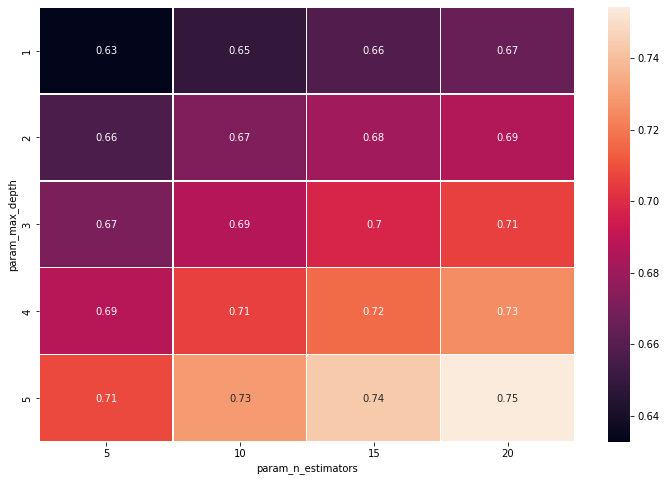

In [34]:
# HERE WE WILL TRY TO SHOW HEAT MAP FOR 

# REFER : https://stackoverflow.com/questions/48791709/how-to-plot-a-heat-map-on-pivot-table-after-grid-search

pvt = pd.pivot_table(pd.DataFrame(clf.cv_results_),
    values='mean_train_score', index='param_max_depth', 
     columns='param_n_estimators') 

 # GIVING SIZE 
plt.figure(figsize=(12,8))
ax=sns.heatmap(pvt,annot=True,linewidths=.10)

# Heat map on  Test data

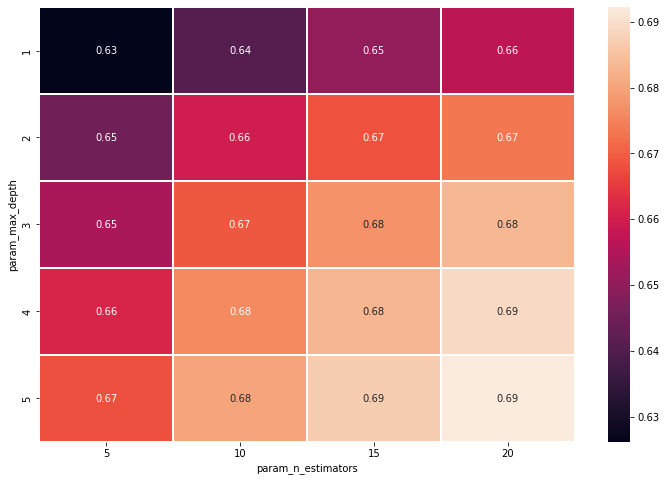

In [35]:
import pandas as pd

# HERE PLOTTING HEAT MAP FOR TEST DATA 


 #https://stackoverflow.com/questions/48791709/how-to-plot-a-heat-map-on-pivot-table-after-grid-search

pvt = pd.pivot_table(pd.DataFrame(clf.cv_results_),
    values='mean_test_score', index='param_max_depth', 
    columns='param_n_estimators') #https://stackoverflow.com/questions/48791709/how-to-plot-a-heat-map-on-pivot-table-after-grid-search

    # GIVING SIZE TO HEATMAP
plt.figure(figsize=(12,8))
ax=sns.heatmap(pvt,annot=True,linewidths=.5)

#Roc Plot Of Train And Test Data



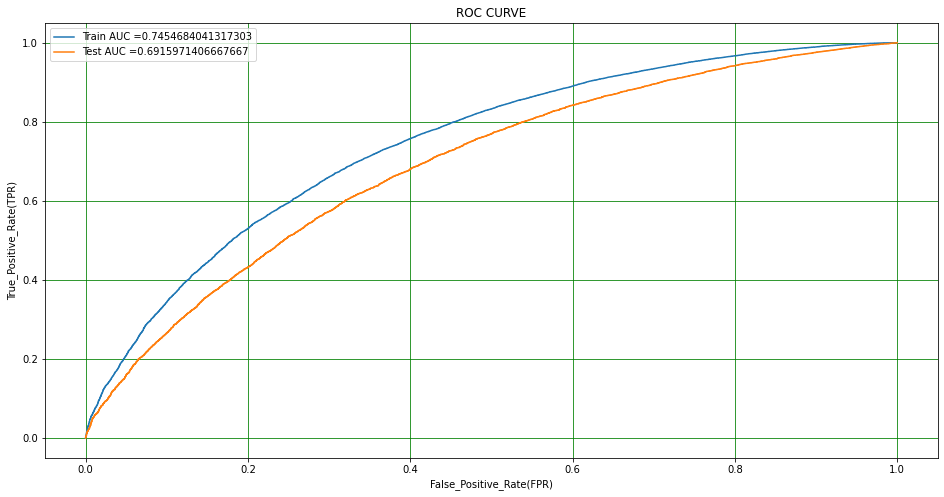

In [36]:
# REFER : https://stackoverflow.com/questions/25009284/how-to-plot-roc-curve-in-python

model_set1=GradientBoostingClassifier(max_depth = clf.best_params_["max_depth"], n_estimators= clf.best_params_["n_estimators"])
model_set1.fit(X_train_set_1,y_train)


# converting train and test output into probability
y_train_probs = clf.predict_proba(X_train_set_1)[:,1] # converting train and test output into probability
y_test_probs= clf.predict_proba(X_test_set_one )[:,1]

 # storing values of fpr and tpr
train_fpr, train_tpr, tr_thresholds = roc_curve(y_train, y_train_probs)
test_fpr, test_tpr, te_thresholds = roc_curve(y_test, y_test_probs)


# PLOTING THE ROC CURVE 
plt.figure(figsize=(16,8))
plt.plot(train_fpr, train_tpr, label="Train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="Test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()

# NOW WE LABEL THE PLOT X AND Y 
plt.xlabel("False_Positive_Rate(FPR)")
plt.ylabel("True_Positive_Rate(TPR)") 
# TITLE OF THE CURVE IS ROC CURVE 
plt.title("ROC CURVE")

# DEFINING THE GRID PARAMETERS 
plt.grid(color='green',lw=0.8)

#Confusion Matrix


In [ ]:
# REFER : https://stackoverflow.com/questions/35572000/how-can-i-plot-a-confusion-matrix

def find_best_threshold(threshould, fpr, tpr):
    Thres = threshould[np.argmax(tpr*(1-fpr))]

    # (tpr*(1-fpr)) will be maximum if your fpr is very low and tpr is very high
    print("the maximum value of tpr*(1-fpr)", max(tpr*(1-fpr)), "for threshold", np.round(Thres,3))
    return Thres

# DEFINING THE THRESHOLD VALUE IF VALUE GREATHER THAN THRESHOLD THEN 1 AND IF ITS LESS THAN THEN ITS 0
def predict_with_best_t(proba, threshould):
    predictions = []
    for i in proba:
        if i>=threshould:
            predictions.append(1)
        else:
            predictions.append(0)
    return predictions 

#Train Data


In [ ]:
best_t = find_best_threshold(tr_thresholds, train_fpr, train_tpr)

# PLOTTING THE CONFUSION MATRIX OF TRAIN DATA 

# https://stackoverflow.com/questions/35572000/how-can-i-plot-a-confusion-matrix
cm=metrics.confusion_matrix(y_train,predict_with_best_t(y_train_probs, best_t))  # https://stackoverflow.com/questions/35572000/how-can-i-plot-a-confusion-matrix

print("CONFUSION MATRIX OF TRAIN DATA")
print("\n")
print(cm)
sns.heatmap(cm, annot=True, fmt='d',cmap='RdGy',annot_kws = {"size":16})
plt.ylabel('True Label',size=12)
plt.xlabel('Predicted Label',size=12)
plt.title('Train Data Confusion Matrix',size=12)

#Test Data


In [ ]:
best_t = find_best_threshold(te_thresholds, test_fpr, test_tpr)
cm=metrics.confusion_matrix(y_test,predict_with_best_t(y_test_probs, best_t))
  

# PLOTTING THE CONFUSION MATRIX OF TRAIN DATA 

print("CONFUSION MATRIX OF TEST DATA")
print('\n')
print(cm)
sns.heatmap(cm, annot=True, fmt='d',cmap='RdGy',annot_kws = {"size":16})
plt.ylabel('True Label',size=12)
plt.xlabel('Predicted Label',size=12)
plt.title('Test Data Confusion Matrix',size=12)

#GRADIENT BOOSTING CLASSIFIER USING GRID SEARCH CROSS VALIDATION (SET - 2)


In [40]:

from sklearn.ensemble import GradientBoostingClassifier                
from sklearn.model_selection import GridSearchCV   
parameters = {"max_depth":[1,2,3,4,5],    # MAX DEPTH WE HAVE TAKEN 5
              "n_estimators":[5,10,15,20] }    # number of ESTIMATERS 

# refer : https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingClassifier.html


clf = GridSearchCV(GradientBoostingClassifier(),
                   parameters,
                   cv=5, 
                   scoring='roc_auc',
                   return_train_score=True,
                   n_jobs=-1)

clf.fit(X_train_set_1,y_train)              # FITTING OUR DATA                                                                                   

GridSearchCV(cv=5, estimator=GradientBoostingClassifier(), n_jobs=-1,
             param_grid={'max_depth': [1, 2, 3, 4, 5],
                         'n_estimators': [5, 10, 15, 20]},
             return_train_score=True, scoring='roc_auc')

In [41]:
train_auc= clf.cv_results_['mean_train_score']
train_auc_std= clf.cv_results_['std_train_score']
cv_auc = clf.cv_results_['mean_test_score'] 
cv_auc_std= clf.cv_results_['std_test_score']


In [54]:
#HERE I M TRYING TO GET THE BEST VALUE FOR ALGO  
print('THE BEST CLF SCORE IS : ',clf.best_score_)

# THE I M TRYING TO FINDOUT THAT WHAT SHOULD BE BEST VALUE FOR GBDT PARAMETERS VALUE 
print('BEST VALUE FOR HYPERPARAMETER : ',clf.best_params_) 

THE BEST CLF SCORE IS :  0.6925556117327589
BEST VALUE FOR HYPERPARAMETER :  {'max_depth': 5, 'n_estimators': 20}


#Plotting Hyperparameter v/s Auc
Train Data


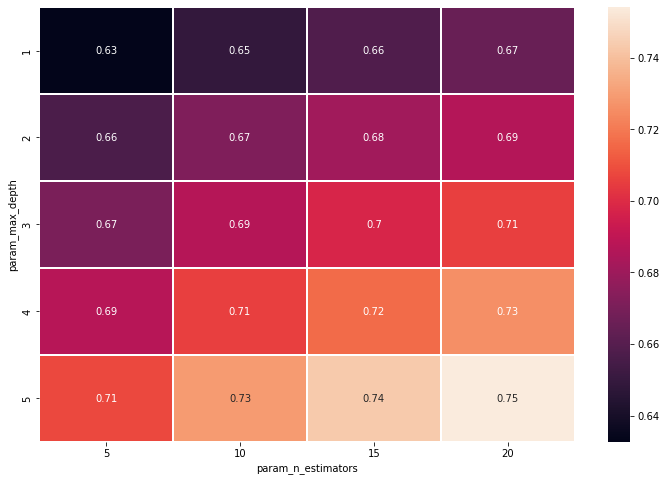

In [56]:
import pandas as pd

# refer : #https://stackoverflow.com/questions/48791709/how-to-plot-a-heat-map-on-pivot-table-after-grid-search


pvt = pd.pivot_table(pd.DataFrame(clf.cv_results_),
    values='mean_train_score', index='param_max_depth',
     columns='param_n_estimators') 


plt.figure(figsize=(12,8))
ax=sns.heatmap(pvt,annot=True,linewidths=.8)

#Cross Validation data


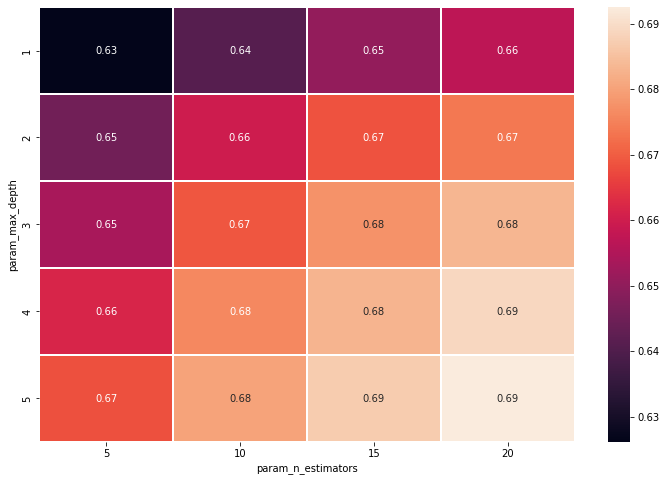

In [57]:
import pandas as pd

# REFER : https://stackoverflow.com/questions/48791709/how-to-plot-a-heat-map-on-pivot-table-after-grid-search


pvt = pd.pivot_table(pd.DataFrame(clf.cv_results_),
    values='mean_test_score', index='param_max_depth', 
    columns='param_n_estimators')  

plt.figure(figsize=(12,8))           
ax=sns.heatmap(pvt,annot=True,linewidths=.8)

#Roc Plot Of Train And Test Data



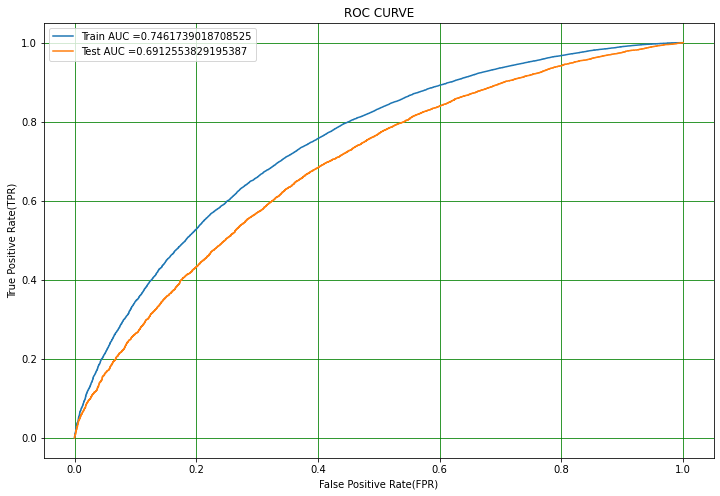

In [58]:
# refer : # REFER : https://stackoverflow.com/questions/25009284/how-to-plot-roc-curve-in-python


model_set2=GradientBoostingClassifier(max_depth = clf.best_params_["max_depth"], n_estimators= clf.best_params_["n_estimators"])
model_set2.fit(X_train_set_1,y_train)

# converting train and test output into probability

y_train_probs = model_set2.predict_proba(X_train_set_1)[:,1] 
y_test_probs= model_set2.predict_proba(X_test_set_one )[:,1]

 # storing values of fpr and tpr
train_fpr, train_tpr, tr_thresholds = roc_curve(y_train, y_train_probs) # storing values of fpr and tpr
test_fpr, test_tpr, te_thresholds = roc_curve(y_test, y_test_probs)

# PLOTING THE ROC CURVE 
plt.figure(figsize=(12,8))
plt.plot(train_fpr, train_tpr, label="Train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="Test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()

# NOW WE LABEL THE PLOT X AND Y 
plt.xlabel("False Positive Rate(FPR)")
plt.ylabel("True Positive Rate(TPR)")

# TITLE OF THE CURVE IS ROC CURVE 
plt.title("ROC CURVE")
plt.grid(color='green',lw=0.8)

#Confusion Matrix


In [ ]:
def find_best_threshold(threshould, fpr, tpr):
    t = threshould[np.argmax(tpr*(1-fpr))]
    # (tpr*(1-fpr)) will be maximum if your fpr is very low and tpr is very high
    print("the maximum value of tpr*(1-fpr)", max(tpr*(1-fpr)), "for threshold", np.round(t,3))
    return t

# DEFINING THE THRESHOLD VALUE IF VALUE GREATHER THAN THRESHOLD THEN 1 AND IF ITS LESS THAN THEN ITS 0
def predict_with_best_t(proba, threshould):
    predictions = []
    for i in proba:    
        if i>=threshould:
            predictions.append(1)
        else:
            predictions.append(0)
    return predictions

#Train Data


the maximum value of tpr*(1-fpr) 0.46420746147631475 for threshold 0.842
CONFUSION MATRIX OF TRAIN DATA


==>==>==>==>==>==>==>==>==>==>==>==>==>==>==>==>==>==>==>==>==>==>==>==>==>==>==>==>==>==>==>==>==>==>==>==>==>==>==>==>==>==>==>==>==>==>==>==>==>==>
[[ 7374  3709]
 [18777 43336]]


Text(0.5, 1.0, 'Train Data Confusion Matrix')

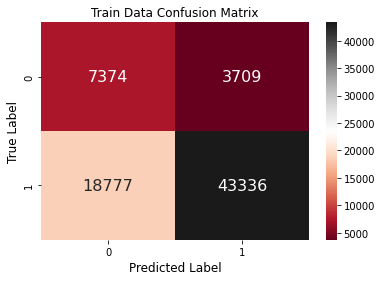

In [62]:
best_t = find_best_threshold(tr_thresholds, train_fpr, train_tpr)
CONFUSION_MATRIX=metrics.confusion_matrix(y_train,predict_with_best_t(y_train_probs, best_t))  


# REFER :  https://stackoverflow.com/questions/35572000/how-can-i-plot-a-confusion-matrix
# REFER :  https://stackoverflow.com/questions/35572000/how-can-i-plot-a-confusion-matrix

print("CONFUSION MATRIX OF TRAIN DATA")
print("\n")
print('==>'*50)
print(CONFUSION_MATRIX)
sns.heatmap(CONFUSION_MATRIX, annot=True, fmt='d',cmap='RdGy',annot_kws = {"size":16})
plt.ylabel('True Label',size=12)
plt.xlabel('Predicted Label',size=12)
plt.title('Train Data Confusion Matrix',size=12)

#Test Data


the maximum value of tpr*(1-fpr) 0.4130918329880019 for threshold 0.845
CONFUSION MATRIX OF TEST DATA


==>==>==>==>==>==>==>==>==>==>==>==>==>==>==>==>==>==>==>==>==>==>==>==>==>==>==>==>==>==>==>==>==>==>==>==>==>==>==>==>==>==>==>==>==>==>==>==>==>==>
[[ 3381  2078]
 [10188 20405]]


Text(0.5, 1.0, 'Test Data Confusion Matrix')

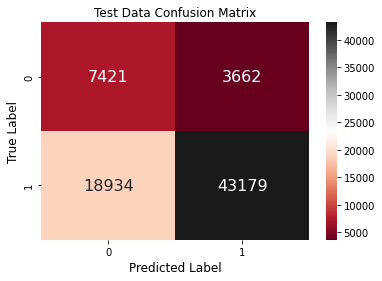

In [63]:
# REFER : https://stackoverflow.com/questions/35572000/how-can-i-plot-a-confusion-matrix
best_t = find_best_threshold(te_thresholds, test_fpr, test_tpr)
confusion_matrix =metrics.confusion_matrix(y_test,predict_with_best_t(y_test_probs, best_t))


# REFER :  https://stackoverflow.com/questions/35572000/how-can-i-plot-a-confusion-matrix
# REFER :  https://stackoverflow.com/questions/35572000/how-can-i-plot-a-confusion-matrix

print("CONFUSION MATRIX OF TEST DATA")
print('\n')
print('==>'*50)
print(confusion_matrix)       
sns.heatmap(cm, annot=True, fmt='d',cmap='RdGy',annot_kws = {"size":16})
plt.ylabel('True Label',size=12) 
plt.xlabel('Predicted Label',size=12)
plt.title('Test Data Confusion Matrix',size=12)

#Summary


In [60]:
# refer: https://ptable.readthedocs.io/en/latest/tutorial.html
# http://zetcode.com/python/prettytable/

# here we are using the pretty table to show our model performence 
table=PrettyTable(hrules=ALL)
table.field_names = [ "SI.N0","Vectorizer", "Model", "Hyper Parameter", "Test-AUC"]
table.add_row([1,"TFIDF", "GRADIENT_BOOSTING_CLASSIFIER", "max_depth =  5 , n_estimators=20", 0.691597])
table.add_row([2,"TFIDF W2V", "GRADIENT_BOOSTING_CLASSIFIER","max_depth =5, n_estimators=20", 0.691255])
print(table)

+-------+------------+------------------------------+----------------------------------+----------+
| SI.N0 | Vectorizer |            Model             |         Hyper Parameter          | Test-AUC |
+-------+------------+------------------------------+----------------------------------+----------+
|   1   |   TFIDF    | GRADIENT_BOOSTING_CLASSIFIER | max_depth =  5 , n_estimators=20 | 0.691597 |
+-------+------------+------------------------------+----------------------------------+----------+
|   2   | TFIDF W2V  | GRADIENT_BOOSTING_CLASSIFIER |  max_depth =5, n_estimators=20   | 0.691255 |
+-------+------------+------------------------------+----------------------------------+----------+
